# DEA tool for BTQ Financial

## Environment setting 

### Installing & Importing libraries/modules

In [1]:
!pip install pyDEA
!pip install PuLP

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyDEA as dea
import math
import numpy as np

from pulp import *

%matplotlib inline

In [2]:
# The core DEA class, setting up and solving the linear programming
# problems using PuLP.

# import pandas as pd
# import pulp


class DEAProblem:

    """
    A container for the elements of a data envelopment analysis problem. Sets
    up the linear programmes and solves them with pulp.
    Requires:
        inputs: a pandas dataframe of the inputs to the DMUs
        outputs: a pandas dataframe of the outputs from the DMUs
        kind: 'VRS' or 'CRS'
        in_weights: the weight restriction to apply to all inputs to all DMUs
                    (default is [0, inf])
        out_weights: the weight restriction to apply to all outputs to all DMUs
                     (default is [0, inf)
    Weight restrictions must be specified as a list. To specify only one bound
    leave the other as None, eg. in_weights=[1, None].
    """

    def __init__(self, inputs, outputs, returns='CRS',
                 in_weights=[0, None], out_weights=[0, None]):
        """
        Set up the DMUs' problems, ready to solve.
        """
        self.inputs = _to_dataframe(inputs)
        self.outputs = _to_dataframe(outputs)
        self.returns = returns

        self.J, self.I = self.inputs.shape  # no of firms, inputs
        _, self.R = self.outputs.shape  # no of outputs
        self._i = range(self.I)  # inputs
        self._r = range(self.R)  # outputs
        self._j = range(self.J)  # DMUs

        self._in_weights = in_weights  # input weight restrictions
        self._out_weights = out_weights  # output weight restrictions

        # creates dictionary of pulp.LpProblem objects for the DMUs
        self.dmus = self._create_problems()

    def _create_problems(self):
        """
        Iterate over the inputs and create a dictionary of LP problems, one
        for each DMU.
        """

        dmu_dict = {}
        for j0 in self._j:
            dmu_dict[j0] = self._make_problem(j0)
        return dmu_dict

    def _make_problem(self, j0):
        """
        Create a pulp.LpProblem for a DMU.
        """

        # Set up pulp
        prob = pulp.LpProblem("".join(["DMU_", str(j0)]), pulp.LpMaximize)
        self.inputWeights = pulp.LpVariable.dicts("inputWeight", (self._j, self._i),
                                                  lowBound=self._in_weights[0], upBound=self._in_weights[1])
        self.outputWeights = pulp.LpVariable.dicts("outputWeight", (self._j, self._r),
                                                   lowBound=self._out_weights[0], upBound=self._out_weights[1])

        # Set returns to scale
        if self.returns == "CRS":
            w = 0
        elif self.returns == "VRS":
            w = pulp.LpVariable.dicts("w", (self._j, self._r))
        else:
            raise Exception(ValueError)

        # Set up objective function
        prob += pulp.LpAffineExpression(
            [(self.outputWeights[j0][r1], self.outputs.values[j0][r1]) for r1 in self._r]) - w

        # Set up constraints
        prob += pulp.LpAffineExpression([(self.inputWeights[j0][i1],
                                          self.inputs.values[j0][i1]) for i1 in self._i]) == 1, "Norm_constraint"
        for j1 in self._j:
            prob += self._dmu_constraint(j0, j1) - \
                w <= 0, "".join(["DMU_constraint_", str(j1)])
        return prob

    def _dmu_constraint(self, j0, j1):
        """
        Calculate and return the DMU constraint for a single DMU's LP problem.
        """

        eOut = pulp.LpAffineExpression(
            [(self.outputWeights[j0][r1], self.outputs.values[j1][r1]) for r1 in self._r])
        eIn = pulp.LpAffineExpression(
            [(self.inputWeights[j0][i1], self.inputs.values[j1][i1]) for i1 in self._i])
        return eOut - eIn

    def _solver(self):
        """
        Iterate over the dictionary of DMUs' problems, solve them, and collate
        the results into a pandas dataframe.
        """

        sol_status = {}
        sol_weights = {}
        sol_efficiency = {}

        for ind, problem in list(self.dmus.items()):
            problem.solve()
            sol_status[ind] = pulp.LpStatus[problem.status]
            sol_weights[ind] = {}
            for v in problem.variables():
                sol_weights[ind][v.name] = v.varValue
            sol_efficiency[ind] = pulp.value(problem.objective)
        return sol_status, sol_efficiency, sol_weights

    def _build_weight_results_dict(self, sol_weights):
        """
        Rename weights from input and output column names, then build a
        pandas dataframe of all weights.
        """
        import re
        tmp_dict = {}
        for dmu, d in list(sol_weights.items()):
            tmp_dict[dmu] = {}
            for key, _ in list(d.items()):
                m = re.search(r'[0-9]+$',key)
                i = int(m.group(0))
                if key.startswith("input"):
                    tmp_dict[dmu]["in_" + str(self.inputs.columns[i])] = d[key]
                if key.startswith("output"):
                    tmp_dict[dmu][
                        "out_" + str(self.outputs.columns[i])] = d[key]
        weight_results = pd.DataFrame.from_dict(tmp_dict).T

        return weight_results

    def solve(self, sol_type='technical'):
        """"
        Solve the problem and create attributes to hold the solutions.
        Takes:
            sol_type: 'technical'/'allocative'/'economic'
            dmus: tuple defining range of DMUs to solve for.
        """

        if sol_type == 'technical':
            sol_status, sol_efficiency, sol_weights = self._solver()
            weight_results = self._build_weight_results_dict(sol_weights)
            status_df = pd.Series(sol_status, name='Status')
            status_df.index = self.inputs.index
            efficiency_df = pd.Series(sol_efficiency, name='Efficiency')
            efficiency_df.index = self.inputs.index

            return DEAResults((('Status', status_df),
                               ('Efficiency', efficiency_df),
                               ('Weights', weight_results)))
        else:
            print("Solution type not yet implemented.")
            print("Solving for technical efficiency instead.")
            self.solve()


class DEAResults(dict):

    """
    A class to hold the results of a DEAProblem and provide methods for
    their examination. Essentially a dictionary of pandas Series with
    methods for conducting particular operations on DEA results.
    """

#    def __init__(self):
#        super(DEAResults, self).__init__()
#        pass

    def find_comparators(self, dmu):
        """
        Return the DMUs that form the frontier for the specified DMU.
        """
        pass

    def env_corr(self, env_vars, coeff_plot=False, qq_plot=False):
        """
        Determine correlations with environmental/non-discretionary variables
        using a logit regression. Tobit will be implemented when available
        upstream in statsmodels.
        Takes:
            env_vars: A pandas dataframe of environmental variables
        Returns:
            corr_mod: the statsmodels' model instance containing the inputs
                      and results from the logit model.
        Note that there can be no spaces in the variables' names.
        """

        import matplotlib.pyplot as plt
        from statsmodels.regression.linear_model import OLS
        from statsmodels.graphics.gofplots import qqplot
        from seaborn import coefplot

        env_data = _to_dataframe(env_vars)
        corr_data = env_data.join(self['Efficiency'])
        corr_mod = OLS.from_formula(
            "Efficiency ~ " + " + ".join(env_vars.columns), corr_data)
        corr_res = corr_mod.fit()

        #plot coeffs
        if coeff_plot:
            coefplot("Efficiency ~ " + " + ".join(env_vars.columns),
                     data=corr_data)
            plt.xticks(rotation=45, ha='right')
            plt.title('Regression coefficients and standard errors')

        #plot qq of residuals
        if qq_plot:
            qqplot(corr_res.resid, line='s')
            plt.title('Distribution of residuals')

        print(corr_res.summary())

        return corr_res


def _to_dataframe(indata):
    """
    Indexers require input to be a dataframe but the user may pass a
    series. Check and cast series to dataframes.
    """

    if type(indata) == pd.core.frame.DataFrame:
        return indata
    elif type(indata) == pd.core.series.Series:
        return pd.DataFrame(indata, columns=['input_data'])
    else:
        raise TypeError(
            "Input data is not a valid pandas DataFrame or Series.")
        
        

class tools:
    # Tools for working with the solved DEA objects.

    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt


    def _all_positive(df):
        """
        Ensure that all values in a dataframe are strictly positive by
        adding a constant.
        """

        dfpos = pd.DataFrame(index=df.index)
        for ser, vals in list(df.items()):
            if vals.min() <= 0:
                dfpos[ser] = vals + np.abs(vals.min()) + 1
        return dfpos


    def normalise_df(df, all_positive=False):
        """
        Normalise the series in a dataframe to z-scores,
        """

        dfnorm = pd.DataFrame(index=df.index)
        for ind, ser in list(df.items()):
            dfnorm[ind] = (ser - ser.mean()) / ser.std()

        if all_positive:
             dfnorm = _all_positive(dfnorm)

        return dfnorm


    def deaPCA(df, allres=False, normalise=False, plot=True):
        """
        Extract principal components from pandas dataframe and shift distribution
        so that all values are strictly positive, as required for DEA.
        Takes:
            df: A dataframe of series to run the PCA on.
            allres: Boolean. Set True if you would like to get the PCA object
                    returned instead of the transformed data. This can be
                    useful if you wish to use the entire results of the PCA.
                    The object is a fit_transformed sklearn.decomposition.PCA
                    object.
            normalise: Boolean. Set True to normalise the series to a z-score
                    before transforming.
            plot: Should the function display a plot of the variance explained?
        """

        from sklearn.decomposition import PCA as sklearnPCA

        if normalise:
            df = normalise_df(df)

        indat_pca = sklearnPCA()
        indat_transf = pd.DataFrame(
            indat_pca.fit_transform(df.values), index=df.index)

        pca_colnames = ["PCA" + str(i) for i in indat_transf.columns]
        indat_transf.columns = pca_colnames

        indat_transf_pos = _all_positive(indat_transf)

        if plot:
            _, ax1 = plt.subplots()
            ax1.plot(np.array(indat_pca.explained_variance_ratio_).cumsum())
            ax1.bar(np.arange(0.1, len(indat_pca.explained_variance_ratio_), 1),
                    np.array(indat_pca.explained_variance_ratio_))
            ax1.legend(['Cumulative variance explained',
                'Variance explained by component'], loc='center right')
            ax1.set_ylabel('Proportion of variance explained')
            ax1.set_title('Variance explained by each principal component')
            ax1.set_xlim(right=len(indat_pca.explained_variance_ratio_))
            ax1.set_ylim(top=1)

        if allres:
            return indat_pca
        else:
            return indat_transf_pos

## Importing the inputs/outputs data

In [3]:
data = pd.read_csv('data.csv')

### Displaying the dataset

In [4]:
data.head()

,Client,CM hours,FA hours,Controller hours,Offshore hours,Revenue
0,Accion East,363,242,583,2763,246667
1,Advanced Care Alliance-FA,385,36,226,846,176198
2,American Theatre Wing,266,571,345,971,75000
3,Bailey House,836,528,487,3503,411837
4,Billion Oyster Project,263,480,828,2651,60000


In [5]:
data.shape
data.columns.tolist()

['Client',
 'CM hours',
 'FA hours',
 'Controller hours',
 'Offshore hours',
 'Revenue']

### Displaying the inputs

In [6]:
input_cols = ['CM hours', 'FA hours', 'Controller hours', 'Offshore hours']

input_data = data[input_cols]

input_data.head()

,CM hours,FA hours,Controller hours,Offshore hours
0,363,242,583,2763
1,385,36,226,846
2,266,571,345,971
3,836,528,487,3503
4,263,480,828,2651


### Displaying the outputs

In [7]:
output_cols = ['Revenue']

output_data = data[output_cols]

output_data.head()

,Revenue
0,246667
1,176198
2,75000
3,411837
4,60000


### Constructing the distributions of the dataset's input attributes

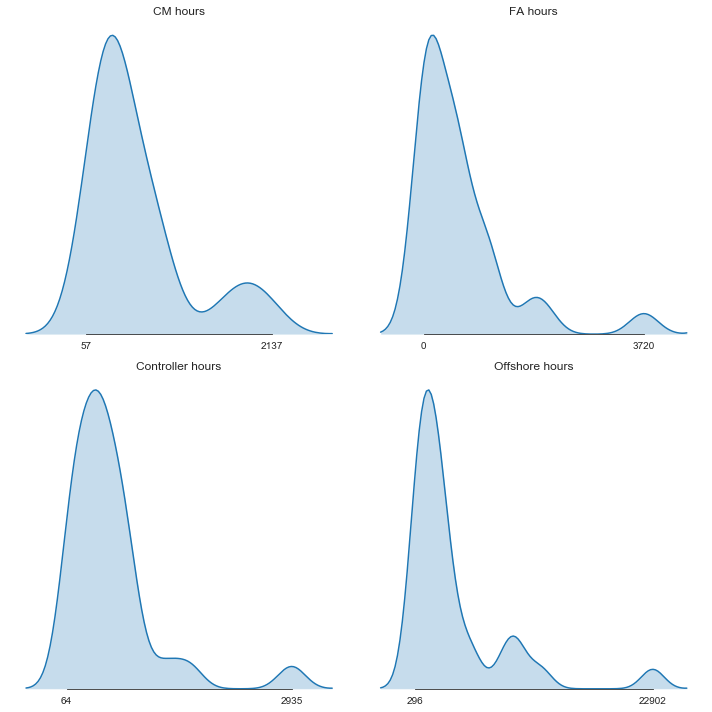

In [8]:
input_cols = ['CM hours', 'FA hours', 'Controller hours', 'Offshore hours']

output_cols = ['Revenue']

inoutdat = data[input_cols + output_cols].dropna(how='any')
inoutdat.describe().T[:]
sns.set_style("white")

num_plots = len(input_cols)
n = int(math.ceil(math.sqrt(num_plots)))

fig = plt.figure(figsize=(10, 10))
axes = [plt.subplot(n, n, i) for i in range(1, num_plots + 1)]

i = 0
for k, v in inoutdat[input_cols].iteritems():
    ax = axes[i]
    sns.kdeplot(v, shade=True, ax=ax, legend=False)
    [label.set_visible(False) for label in ax.get_yticklabels()]
    ax.xaxis.set_ticks([v.min(), v.max()])
    ax.set_title(k)
    i += 1
sns.despine(left=True, trim=True, fig=fig)
plt.tight_layout()

### Identifying the correlation between the dataset's input attributes

,CM hours,FA hours,Controller hours,Offshore hours
CM hours,1,0.74,0.65,0.69
FA hours,0.74,1,0.66,0.94
Controller hours,0.65,0.66,1,0.74
Offshore hours,0.69,0.94,0.74,1


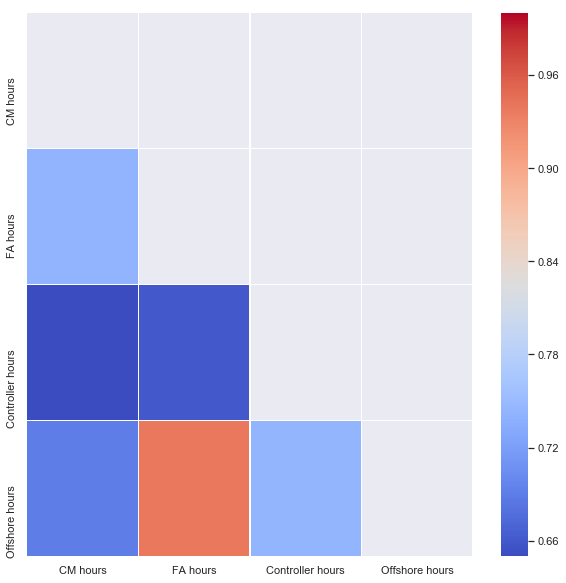

In [9]:
fig = plt.figure(figsize=(10, 10))

corr = inoutdat[input_cols].corr()
sns.set()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
with sns.plotting_context(rc={"figure.figsize": (15, 6)}):
    sns.heatmap(corr, linewidths=0.5, mask=mask, cmap='coolwarm')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

### Sorting the dataset's input attributes by size
#### Visualizing the dataset's input attributes by size

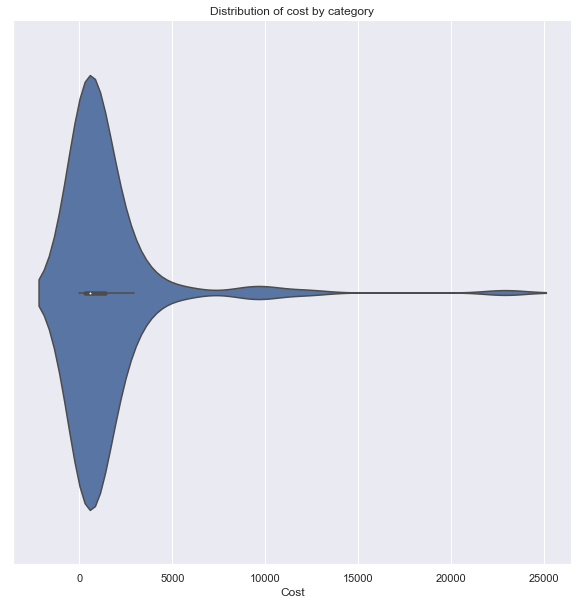

In [10]:
fig = plt.figure(figsize=(10, 10))

med = inoutdat[input_cols].median()
med.sort_values(ascending=False)

# Make a dictionary with one specific color per group:
my_pal = {"versicolor": "g", "setosa": "b", "virginica":"m"}

with sns.plotting_context(rc={"figure.figsize": (15, 6)}):
    sns.violinplot(inoutdat[med.index])
plt.xlabel("Cost")
plt.title("Distribution of cost by category")
sns.despine()

## Building (Setting up) and solving the DEA object¶

### Calling the DEA object

In [11]:
%time
primDEA = DEAProblem(inoutdat[med.index[:5]], inoutdat[output_cols], returns='CRS')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


### Solving the DEA object

In [12]:
primResults = primDEA.solve()

In [13]:
primResults

{'Status': 0     Optimal
 1     Optimal
 2     Optimal
 3     Optimal
 4     Optimal
 5     Optimal
 6     Optimal
 7     Optimal
 8     Optimal
 9     Optimal
 10    Optimal
 11    Optimal
 12    Optimal
 13    Optimal
 14    Optimal
 15    Optimal
 16    Optimal
 17    Optimal
 18    Optimal
 19    Optimal
 20    Optimal
 21    Optimal
 22    Optimal
 23    Optimal
 24    Optimal
 25    Optimal
 26    Optimal
 27    Optimal
 28    Optimal
 Name: Status, dtype: object, 'Efficiency': 0     0.564764
 1     0.811164
 2     0.300829
 3     0.739728
 4     0.156879
 5     0.351872
 6     0.625607
 7     0.326842
 8     0.449203
 9     0.553395
 10    0.968697
 11    0.539752
 12    1.000000
 13    0.845773
 14    0.535452
 15    0.473220
 16    0.539036
 17    0.407605
 18    0.598145
 19    0.956975
 20    1.000000
 21    0.229678
 22    0.320057
 23    0.160241
 24    0.603011
 25    0.629716
 26    1.000000
 27    0.808592
 28    0.532902
 Name: Efficiency, dtype: float64, 'Weights':   

### Displaying the results' status

In [14]:
primResults['Status']

0     Optimal
1     Optimal
2     Optimal
3     Optimal
4     Optimal
5     Optimal
6     Optimal
7     Optimal
8     Optimal
9     Optimal
10    Optimal
11    Optimal
12    Optimal
13    Optimal
14    Optimal
15    Optimal
16    Optimal
17    Optimal
18    Optimal
19    Optimal
20    Optimal
21    Optimal
22    Optimal
23    Optimal
24    Optimal
25    Optimal
26    Optimal
27    Optimal
28    Optimal
Name: Status, dtype: object

In [15]:
primResults['Efficiency']

0     0.564764
1     0.811164
2     0.300829
3     0.739728
4     0.156879
5     0.351872
6     0.625607
7     0.326842
8     0.449203
9     0.553395
10    0.968697
11    0.539752
12    1.000000
13    0.845773
14    0.535452
15    0.473220
16    0.539036
17    0.407605
18    0.598145
19    0.956975
20    1.000000
21    0.229678
22    0.320057
23    0.160241
24    0.603011
25    0.629716
26    1.000000
27    0.808592
28    0.532902
Name: Efficiency, dtype: float64

### Displaying the efficiency results (values)

In [16]:
primResults['Efficiency']

0     0.564764
1     0.811164
2     0.300829
3     0.739728
4     0.156879
5     0.351872
6     0.625607
7     0.326842
8     0.449203
9     0.553395
10    0.968697
11    0.539752
12    1.000000
13    0.845773
14    0.535452
15    0.473220
16    0.539036
17    0.407605
18    0.598145
19    0.956975
20    1.000000
21    0.229678
22    0.320057
23    0.160241
24    0.603011
25    0.629716
26    1.000000
27    0.808592
28    0.532902
Name: Efficiency, dtype: float64

### Displaying the weights results (values)

In [17]:
primResults['Weights']

,in_CM hours,in_Controller hours,in_FA hours,in_Offshore hours,out_Revenue
0,0.002137,0.000000,0.000397,0.000046,2.289582e-06
1,0.000000,0.000000,0.000000,0.001182,4.603708e-06
2,0.000000,0.000000,0.000000,0.001030,4.011058e-06
3,0.000000,0.001746,0.000284,0.000000,1.796166e-06
4,0.002441,0.000000,0.000454,0.000053,2.614656e-06
5,0.000366,0.000000,0.000068,0.000008,3.915826e-07
6,0.000000,0.007144,0.001162,0.000000,7.351264e-06
7,0.000000,0.005882,0.000957,0.000000,6.052632e-06
8,0.000000,0.000956,0.000000,0.000260,1.995661e-06
9,0.000847,0.000000,0.000000,0.000282,1.932703e-06


### Plotting the frequency distribution of the efficiency scores

Text(0.5, 1.0, 'Distribution of efficiency scores')

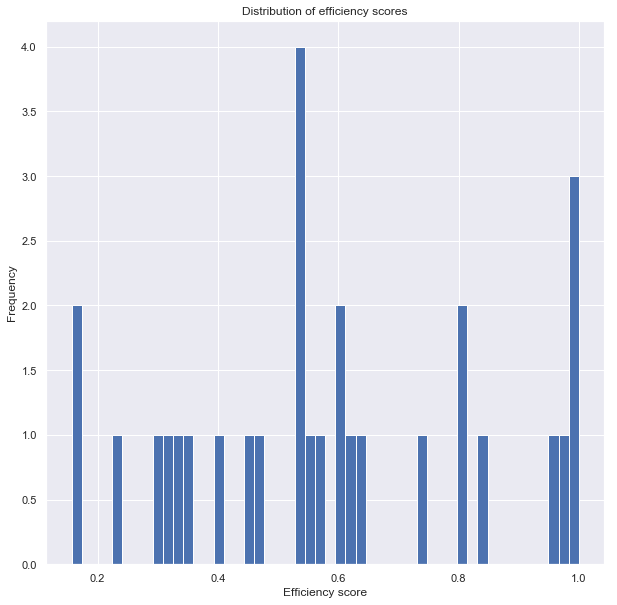

In [18]:
fig = plt.figure(figsize=(10, 10))

primResults['Efficiency'].hist(bins=50)
plt.ylabel('Frequency')
plt.xlabel('Efficiency score')
plt.title('Distribution of efficiency scores')

In [21]:
results_weights = primResults['Weights']
results_efficiency = primResults['Efficiency'].to_frame()

results = pd.concat([results_efficiency, results_weights], axis=1)
results['Client'] = data['Client'].tolist()
results = results[results.columns.tolist()]
results.set_index('Client', inplace=True, drop=True)
results = round(results,2)
results.head()

,Efficiency,in_CM hours,in_Controller hours,in_FA hours,in_Offshore hours,out_Revenue
Client,,,,,,
Accion East,0.56,0.0,0.0,0.0,0.0,0.0
Advanced Care Alliance-FA,0.81,0.0,0.0,0.0,0.0,0.0
American Theatre Wing,0.30,0.0,0.0,0.0,0.0,0.0
Bailey House,0.74,0.0,0.0,0.0,0.0,0.0
Billion Oyster Project,0.16,0.0,0.0,0.0,0.0,0.0


In [22]:
results.to_csv('results.csv')